In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript

require(["https://unpkg.com/higlass-multivec/dist/higlass-multivec"],
    function(hglib) {

});

<IPython.core.display.Javascript object>

In [3]:
%%javascript

require(["https://unpkg.com/higlass-pileup/dist/higlass-pileup.min.js"],
    function(hglib) {

});

<IPython.core.display.Javascript object>

In [5]:
import pysam

filename = '../data/SRR1770413.sorted.short.bam'
indexfile = '../data/SRR1770413.sorted.short.bam.bai'

f = pysam.AlignmentFile(filename, index_filename=indexfile)

In [6]:
import pysam



In [195]:
%%time

import numpy as np
from clodius.tiles.bam import get_cigar_substitutions

filename = '../data/ont.10K.bam'
indexfile = '../data/ont.10K.bam.bai'

f = pysam.AlignmentFile(filename, index_filename=indexfile)

reads = list(f.fetch('chr1', 0, 100000))

chrom_len = 2000000 + 1
match = np.zeros((chrom_len,))

subs = {
    'A': np.zeros((chrom_len,)),
    'C': np.zeros((chrom_len,)),
    'G': np.zeros((chrom_len,)),
    'T': np.zeros((chrom_len,)),
    'S': np.zeros((chrom_len,)),
    'M': np.zeros((chrom_len,)),
    'I': np.zeros((chrom_len,)),
    'D': np.zeros((chrom_len,)),
}

for read in reads:
    ap = [p for p in read.get_aligned_pairs(with_seq=True, matches_only=True) if p[2].islower()]
#     print("read", read.reference_start)
    subs['M'][read.reference_start+1:read.reference_end+1] += 1
    
    for start, op, oplen in get_cigar_substitutions(read):
        if op == 'I':
            subs[op][start+1] += 1
        else:
            subs[op][start+1:start+1 + oplen] += 1
    
#     print("read.cigartuples", get_cigar_substitutions(read))
    for p in ap:
        match[p[1]] -= 1
#         print('read.query_sequence', read.query_sequence)
#         print('read.query_sequence[p[0]]', read.query_sequence[p[0]])
        subs[read.query_sequence[p[0]]][p[1]+1] += 1
#     print(ap)
    

array = {
    'chr1': np.array([subs['A'], subs['T'], subs['G'],
                      subs['C'], subs['S'], subs['M'],
                     subs['I'], subs['D']]).T
}

# array = {
#     'chr1': np.array([
#         np.log(subs['A']),
#         np.log(subs['T']), 
#         np.log(subs['G']),
#         np.log(subs['C']),
#         np.log(subs['S']),
#         np.log(subs['M']),
#         np.log(subs['I']), 
#         np.log(subs['D'])]).T
# }

# subs['A'][2] = 1
# subs['A'][3] = 1

print("reads:", len(reads))
print("match", match[:10])
print("subs_a", log_sum_exp_agg(np.array([np.log(subs['A'][:10])]).T))

reads: 170
match [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
subs_a [[-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]]
CPU times: user 565 ms, sys: 97.2 ms, total: 662 ms
Wall time: 665 ms


<timed exec>:68: RuntimeWarning: divide by zero encountered in log


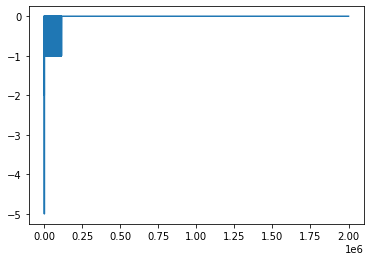

In [196]:
from matplotlib import pyplot
pyplot.plot(range(len(match)), match)

In [192]:
%%time

from scipy.special import logsumexp

from higlass.tilesets import Tileset, multivec

output_file = "/Users/pete/tmp/my_file.multires.hdf5"

def log_sum_exp_agg(x):
    a = x.T.reshape((x.shape[1], -1, 2))
    return logsumexp(a, axis=2).T

def sum_agg(x):
    return np.nansum(x.T.reshape((x.shape[1], -1, 2)), axis=2).T
        
cm.create_multivec_multires(
    array,
    [('chr1', chrom_len)],
#     agg=sum_agg,
    agg=log_sum_exp_agg,
    
    starting_resolution=1,
    row_infos = ['a', "t", 'g', 'c', 's', 'm', 'i', 'd'],
    output_file=output_file,
    tile_size=256
)

colorScale = [
            '#08519c',  #A
            '#6baed6',  #T
            '#993404',  #G
            '#fe9929',  #C
            '#808080',  #S
            '#DCDCDC',  #M
            'rgba(255, 0, 255, 0.5)',      #I
            'rgba(255, 128, 128, 0.5)'      #D
          ]


ts = multivec(output_file)

/Users/pete/miniconda3/lib/python3.8/site-packages/scipy-1.5.2-py3.8-macosx-10.9-x86_64.egg/scipy/special/_logsumexp.py:118: RuntimeWarning: invalid value encountered in log
  out = np.log(s)


CPU times: user 1.48 s, sys: 193 ms, total: 1.68 s
Wall time: 1.7 s


In [193]:
from higlass.tilesets import bam, multivec

ts = multivec(output_file)
bam_ts = bam(filename,indexfile)

In [194]:
import higlass
from higlass.client import Track, View

display, server, viewconf = higlass.display(
    [View([
        Track('top-axis', height=20),
        Track(track_type="horizontal-stacked-bar", position='top', tileset=ts, height=50, options={"colorScale": colorScale} ),
        Track(track_type="pileup", position='top', tileset=bam_ts, height=200 )
    ], initialXDomain = [
        1020,
        1140
      ])]
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'FN7uBpjQQoO1zXzeZ5HLTQ', 'tracks': {'top': [{'ty…

In [113]:
from higlass.tilesets import Tileset, bam

# def bam(filepath, index_filename, uuid=None, **kwargs):
#     from clodius.tiles.bam import tileset_info, tiles

#     return Tileset(
#         uuid=uuid,
#         tileset_info=lambda: tileset_info(filepath),
#         tiles=lambda tile_ids: tiles(filepath, tile_ids, index_filename=index_filename),
#         **kwargs
#     )

bam_ts = bam(filename,indexfile)

In [114]:
import higlass
from higlass.tilesets import Tileset, bam
from higlass.client import Track, View

bam_ts = bam(filename,indexfile)

display, server, viewconf = higlass.display(
    [View([
        Track('top-axis', height=20),
        Track(track_type="pileup", position='top', tileset=bam_ts, height=200 )
    ], initialXDomain = [
        0,
        2000
      ])]
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'KSNHPIFhRbWkKUWm3v0CAw', 'tracks': {'top': [{'ty…